# Economic Performance


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Sources


https://www.kaggle.com/datasets/johnbailey123hd/us-economic-indicators-1980-2023

https://www.kaggle.com/datasets/ogbuzurukelechi/economy-of-the-united-states-by-presidents

https://www.kaggle.com/datasets/georgescutelnicu/us-presidents

https://www.kaggle.com/datasets/leonardjanke/usa-cpi-data-1872-2023


## Helpers


In [110]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Dictionary to map symbols and phrases to their corresponding word representations
    symbol_map = {
        r"\bus\$\b": "usd",
        r"\bnominal\b": "nom",
        r"\bper capita\b": "pc",
        r"\bgovernment\b": "gov",
        "@": "at",
        r"\$": "dollar",
        "#": "number",
        "&": "and",
        "%": "pct",
        r"\*": "star",
        r"\+": "plus",
        r"=": "equals",
    }

    # List of common filler words to remove entirely
    filler_words = [r"\bthe\b", r"\ba\b", r"\ban\b", r"\bof\b", r"\bin\b"]

    # Function to replace symbols with words, remove filler words, and convert to snake_case
    def to_snake_case(col_name: str) -> str:
        # Strip leading and trailing spaces
        col_name = col_name.strip()

        # Remove filler words
        for filler in filler_words:
            col_name = re.sub(filler, "", col_name, flags=re.IGNORECASE)

        # Special case: Handle "US$" placement with underscores
        col_name = re.sub(
            r"(?<!^)(?<!_)\bus\$\b(?!_)(?!$)", r"_usd_", col_name, flags=re.IGNORECASE
        )
        col_name = re.sub(r"^us\$\b(?!_)", r"usd_", col_name, flags=re.IGNORECASE)
        col_name = re.sub(r"\bus\$\b$", r"_usd", col_name, flags=re.IGNORECASE)

        # Replace each symbol or phrase in the dictionary with its corresponding word (case-insensitive)
        for symbol, word in symbol_map.items():
            col_name = re.sub(symbol, word, col_name, flags=re.IGNORECASE)

        # Remove any remaining non-alphanumeric characters except underscores
        col_name = re.sub(r"[^\w\s_]", "", col_name)

        # Replace spaces and dashes with underscores
        col_name = re.sub(r"[\s-]+", "_", col_name)

        # Remove any repeated underscores (i.e., replace multiple underscores with a single one)
        col_name = re.sub(r"_+", "_", col_name)

        # Remove leading or trailing underscores if present
        col_name = col_name.strip("_")

        # Enforce lowercase snake_case column name
        col_name = col_name.lower()

        col_name = re.sub("usdollar", "usd", col_name)
        col_name = re.sub("percent", "pct", col_name)

        return col_name

    # Apply the renaming function to all columns
    df.columns = [to_snake_case(col) for col in df.columns]

    return df

## Datasets


In [111]:
economic_growth_df = pd.read_csv("./datasets/USA Economy Growth.csv")
economic_indicators_df = pd.read_csv("./datasets/US_Economic_Indicators.csv")
presidents_df = pd.read_csv("./datasets/presidents.csv")
market_performance_df = pd.read_csv("./datasets/market-performance-by-president_1.csv")
cpi_df = pd.read_csv("./datasets/shiller_cpi_cleaned_for_kaggle.csv")

## Data Wrangling


In [112]:
# Ensure columns use the same conventions
standardize_columns(economic_growth_df)
standardize_columns(economic_indicators_df)
standardize_columns(presidents_df)
standardize_columns(market_performance_df)
standardize_columns(cpi_df)


# Standarize spellings
economic_growth_df["presidents"] = economic_growth_df["presidents"].str.replace(
    "George Bush", "George H. W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "George HW Bush", "George H. W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "George W Bush", "George W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "Joe Biden ", "Joe Biden"
)

# Ensure correct index usage
economic_growth_df.set_index(["presidents"], drop=False, inplace=True)
market_performance_df.set_index(["president"], drop=False, inplace=True)
presidents_df.set_index(["name"], drop=False, inplace=True)

# Built list of modern presidents
president_names = economic_growth_df["presidents"].unique()
relevant_years = economic_growth_df["year"].unique()

In [135]:
active_columns = [
    # "no",
    "name",
    # "birthplace",
    # "birthday",
    # "life",
    # "height",
    # "children",
    # "religion",
    # "higher_education",
    # "occupation",
    # "military_service",
    # "term",
    "party",
    # "vice_president",
    # "previous_office",
    # "economy",
    # "foreign_affairs",
    # "military_activity",
    # "other_events",
    # "legacy",
    "year",
    "gdp",
    # "gdp_pc_usd_ppp",
    "gdp_bil_usd_nominal",
    "gdp_pc_usd_nom",
    "gdp_growth_pct",
    "inflation_rate_pct",
    "unemployment_pct",
    "gov_debt_pct_gdp",
    # "president",
    # "affliliation",
    # "term_start_date",
    # "starting_dow",
    # "term_end_date",
    # "ending_dow",
    "dow_amount_change",
    "dow_pct_change",
    "cpi",
    # "inflation",
]

In [136]:
modern_presidents_df = presidents_df.query("name in @president_names")
modern_cpi_df = cpi_df.query("year in @relevant_years")[["cpi", "inflation", "year"]]
modern_markets_df = market_performance_df.query("president in @president_names")
modern_markets_df = modern_markets_df.rename(
    columns={
        "amount_change": "dow_amount_change",
        "pct_change": "dow_pct_change",
        "begin_dow": "starting_dow",
        "end_dow": "ending_dow",
        "begin_date": "term_start_date",
        "end_date": "term_end_date",
    }
)

stats_df = modern_presidents_df.join(economic_growth_df).dropna()
stats_df.drop(columns=["presidents"], inplace=True)

stats_df["year"] = stats_df["year"].astype(int)
stats_df["gdp"] = stats_df["gdp"].astype(float)

# Replace percentage strings with numeric values for inflation, unemployment, and debt
stats_df["inflation_rate_pct"] = (
    stats_df["inflation_rate_pct"].str.rstrip("%").astype(float)
)
stats_df["unemployment_pct"] = (
    stats_df["unemployment_pct"].str.rstrip("%").astype(float)
)
stats_df["gov_debt_pct_gdp"] = (
    stats_df["gov_debt_pct_gdp"].str.rstrip("%").astype(float)
)
stats_df = stats_df.join(modern_markets_df)

stats_df = stats_df.merge(modern_cpi_df, how="inner", on="year")

stats_df = stats_df[active_columns]

stats_df
# stats_df[active_columns]

,name,party,year,gdp,gdp_bil_usd_nominal,gdp_pc_usd_nom,gdp_growth_pct,inflation_rate_pct,unemployment_pct,gov_debt_pct_gdp,dow_amount_change,dow_pct_change,cpi
0,Ronald Reagan,Republican,1981,3207.0,3207.0,13948.7,2.50%,10.4,7.6,31.0,1285.94,1.35,94.000
1,Ronald Reagan,Republican,1982,3343.8,3343.8,14405.0,-1.80%,6.2,9.7,34.0,1285.94,1.35,97.600
2,Ronald Reagan,Republican,1983,3634.0,3634.0,15513.7,4.60%,3.2,9.6,37.0,1285.94,1.35,101.300
3,Ronald Reagan,Republican,1984,4037.7,4037.7,17086.4,7.20%,4.4,7.5,38.0,1285.94,1.35,105.300
4,Ronald Reagan,Republican,1985,4339.0,4339.0,18199.3,4.20%,3.5,7.2,41.0,1285.94,1.35,109.300
5,Ronald Reagan,Republican,1986,4579.6,4579.6,19034.8,3.50%,1.9,7.0,46.0,1285.94,1.35,110.500
6,Ronald Reagan,Republican,1987,4855.3,4855.3,20001.0,3.50%,3.6,6.2,48.0,1285.94,1.35,115.400
7,Ronald Reagan,Republican,1988,5236.4,5236.4,21376.0,4.20%,4.1,5.5,50.0,1285.94,1.35,120.500
8,George H. W. Bush,Republican,1989,5641.6,5641.6,22814.1,3.70%,4.8,5.3,51.0,1019.39,0.46,126.100
9,George H. W. Bush,Republican,1990,5963.1,5963.1,23848.0,1.90%,5.4,5.6,54.0,1019.39,0.46,133.800


## Reports


### GDP Change


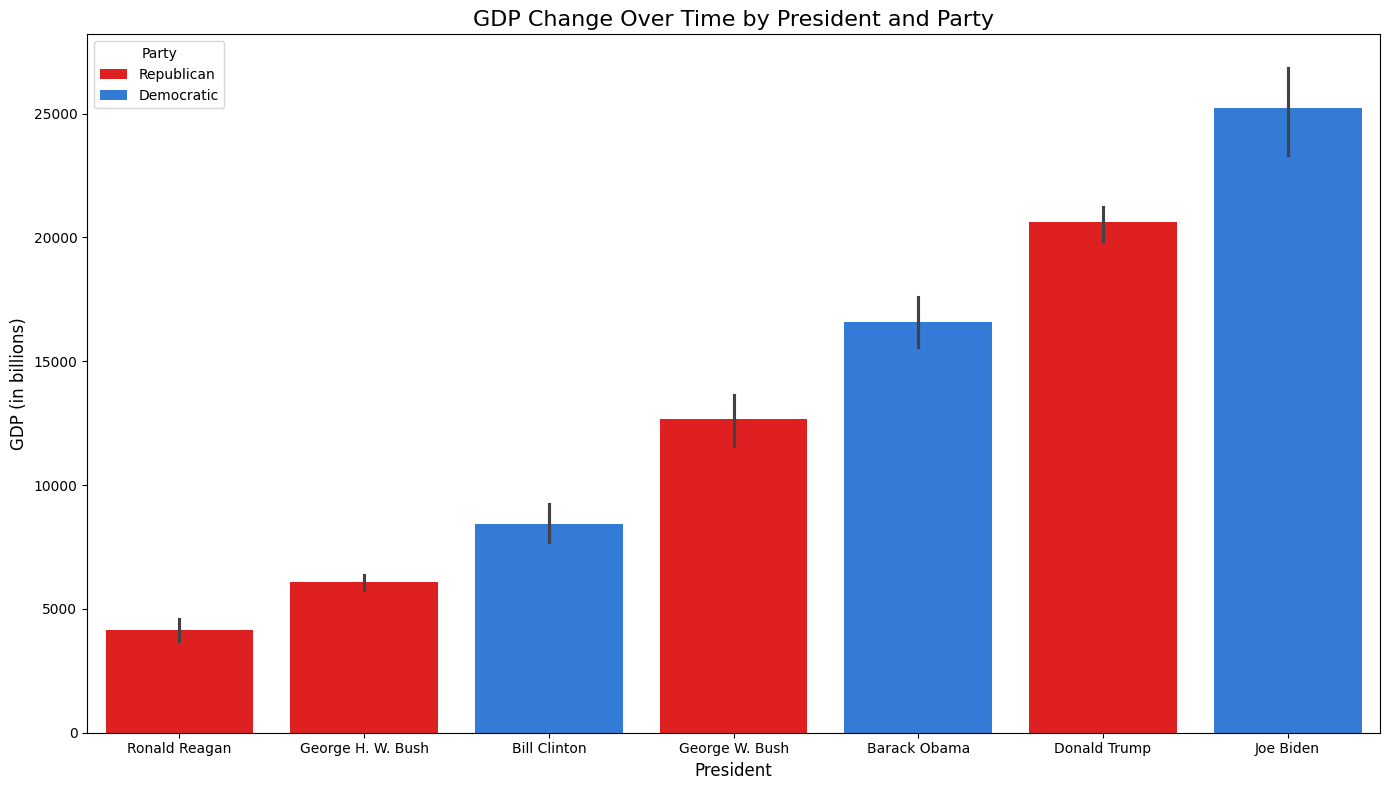

In [115]:
# Define a custom color palette for the parties
party_colors = {
    "Democratic": "#1877F2",  # Democratic Blue
    "Republican": "#FF0000",  # Republican Red
}

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the plot with a custom palette for party colors
sns.barplot(
    x="name",
    y="gdp",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)

# Set axis labels and title
plt.title("GDP Change Over Time by President and Party", fontsize=16)
plt.xlabel("President", fontsize=12)
plt.ylabel("GDP (in billions)", fontsize=12)

# Add legend for party
plt.legend(title="Party")

# Display the plot
plt.tight_layout()
plt.show()

### Inflation Change


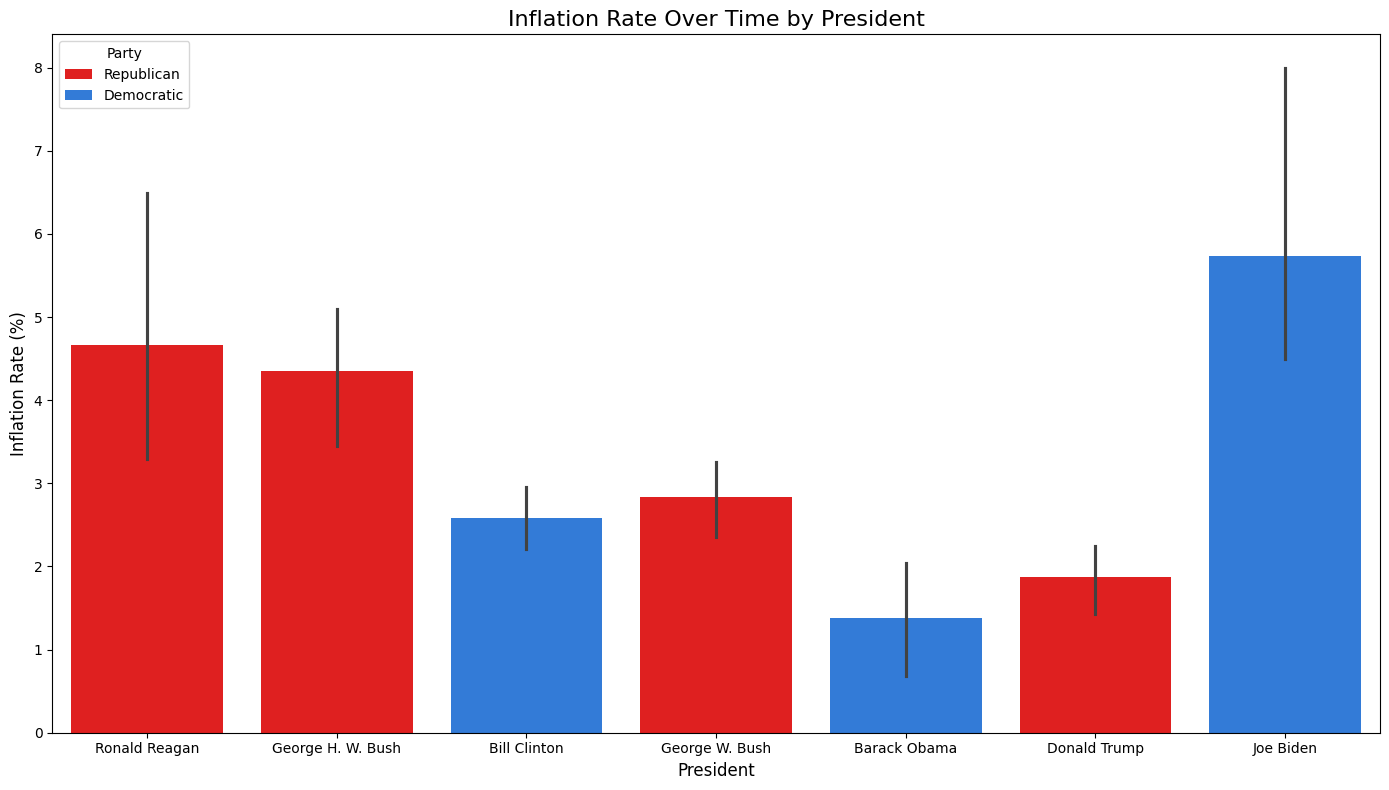

In [116]:
# Plot for Inflation Rate
plt.figure(figsize=(14, 8))
sns.barplot(
    x="name",
    y="inflation_rate_pct",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)
plt.title("Inflation Rate Over Time by President", fontsize=16)
plt.xlabel("President", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.legend(title="Party")
plt.tight_layout()
plt.show()

### Unemployment Change


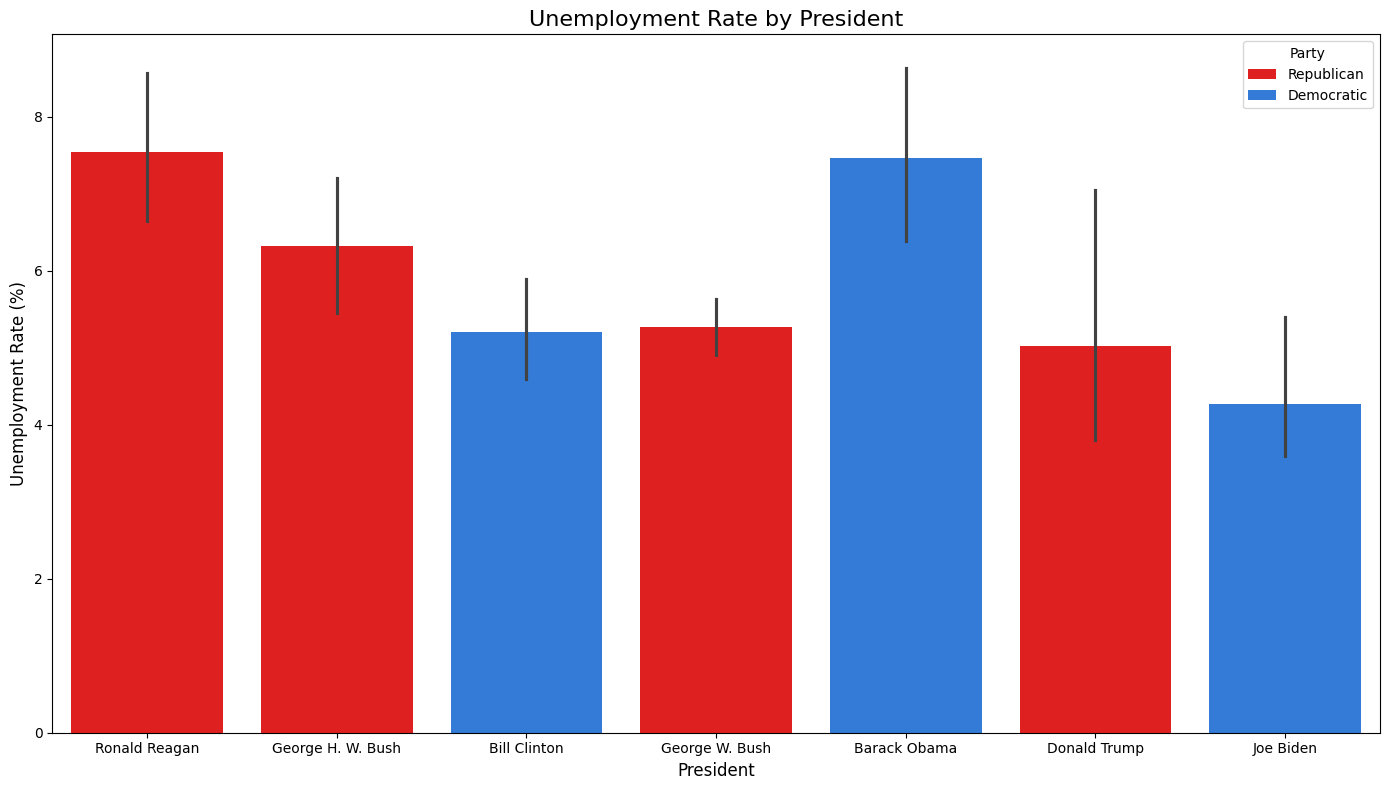

In [117]:
# Plot for Unemployment Rate
plt.figure(figsize=(14, 8))
sns.barplot(
    x="name",
    y="unemployment_pct",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)
plt.title("Unemployment Rate by President", fontsize=16)
plt.xlabel("President", fontsize=12)
plt.ylabel("Unemployment Rate (%)", fontsize=12)
plt.legend(title="Party")
plt.tight_layout()
plt.show()

### Government Debt Change


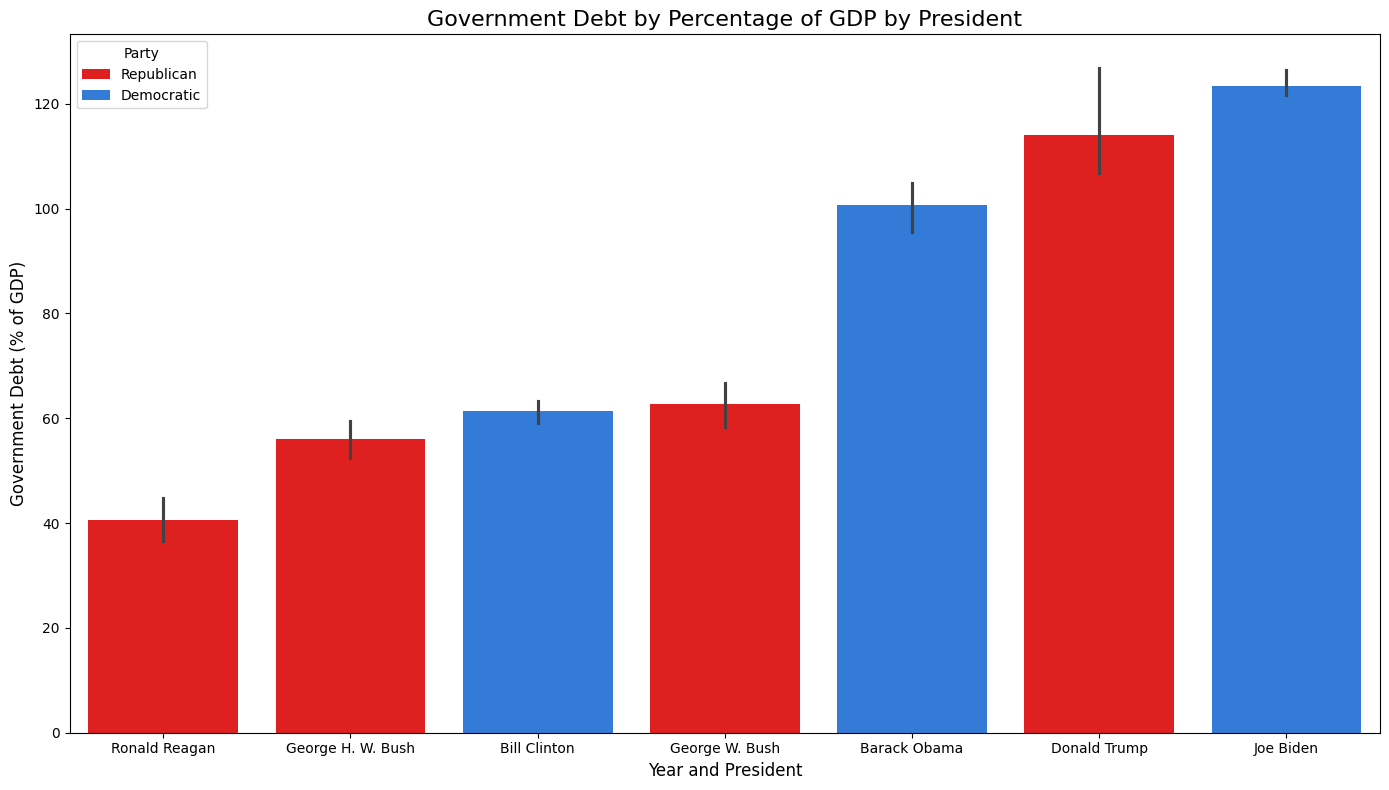

In [118]:
# Plot for Government Debt as Percentage of GDP
plt.figure(figsize=(14, 8))
sns.barplot(
    x="name",
    y="gov_debt_pct_gdp",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)
plt.title("Government Debt by Percentage of GDP by President", fontsize=16)
plt.xlabel("Year and President", fontsize=12)
plt.ylabel("Government Debt (% of GDP)", fontsize=12)
plt.legend(title="Party")
plt.tight_layout()
plt.show()

### Market Change


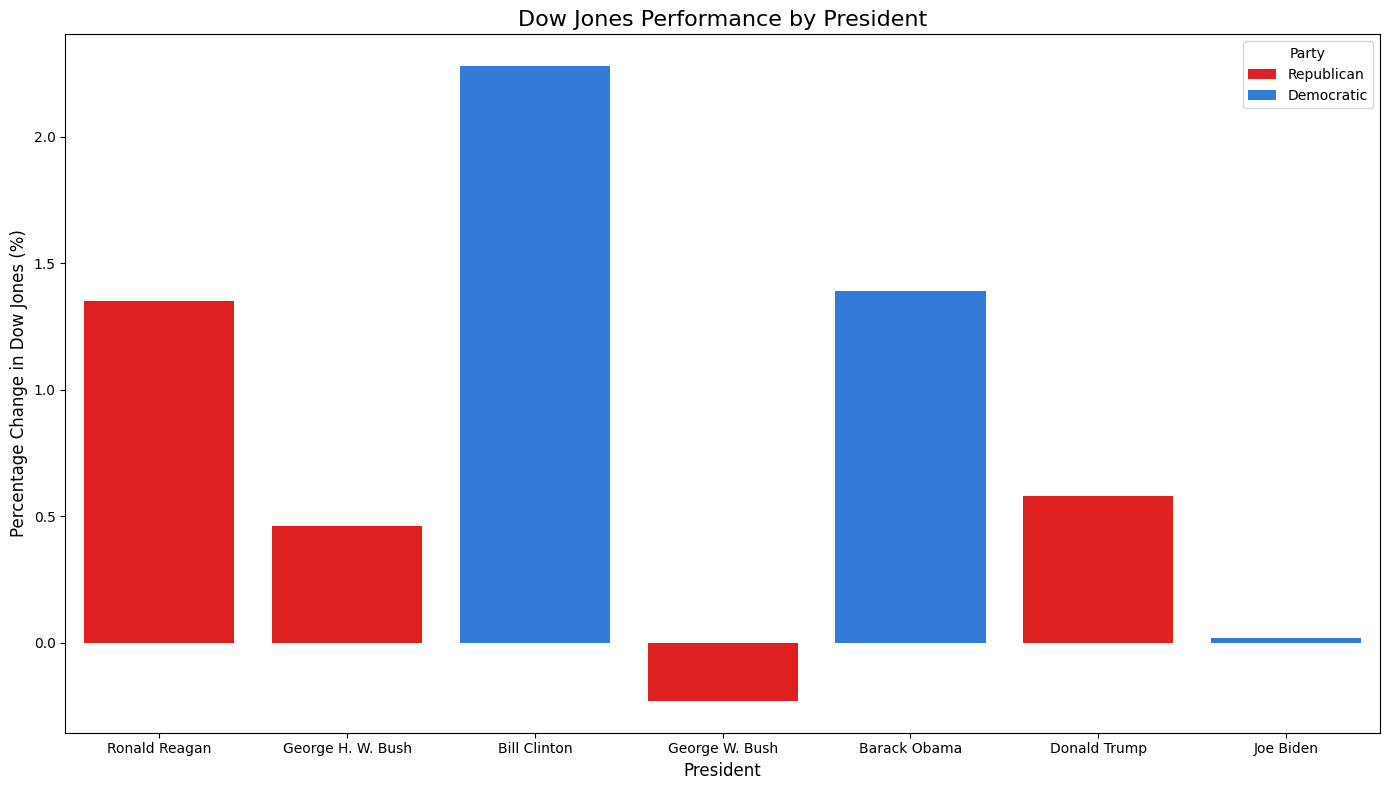

In [120]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Create the bar plot for percentage change in Dow Jones index under each president
sns.barplot(
    x="name",
    y="dow_pct_change",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)

# Set axis labels and title
plt.title("Dow Jones Performance by President", fontsize=16)
plt.xlabel("President", fontsize=12)
plt.ylabel("Percentage Change in Dow Jones (%)", fontsize=12)

# Add a legend for party affiliation
plt.legend(title="Party")

# Display the plot
plt.tight_layout()
plt.show()

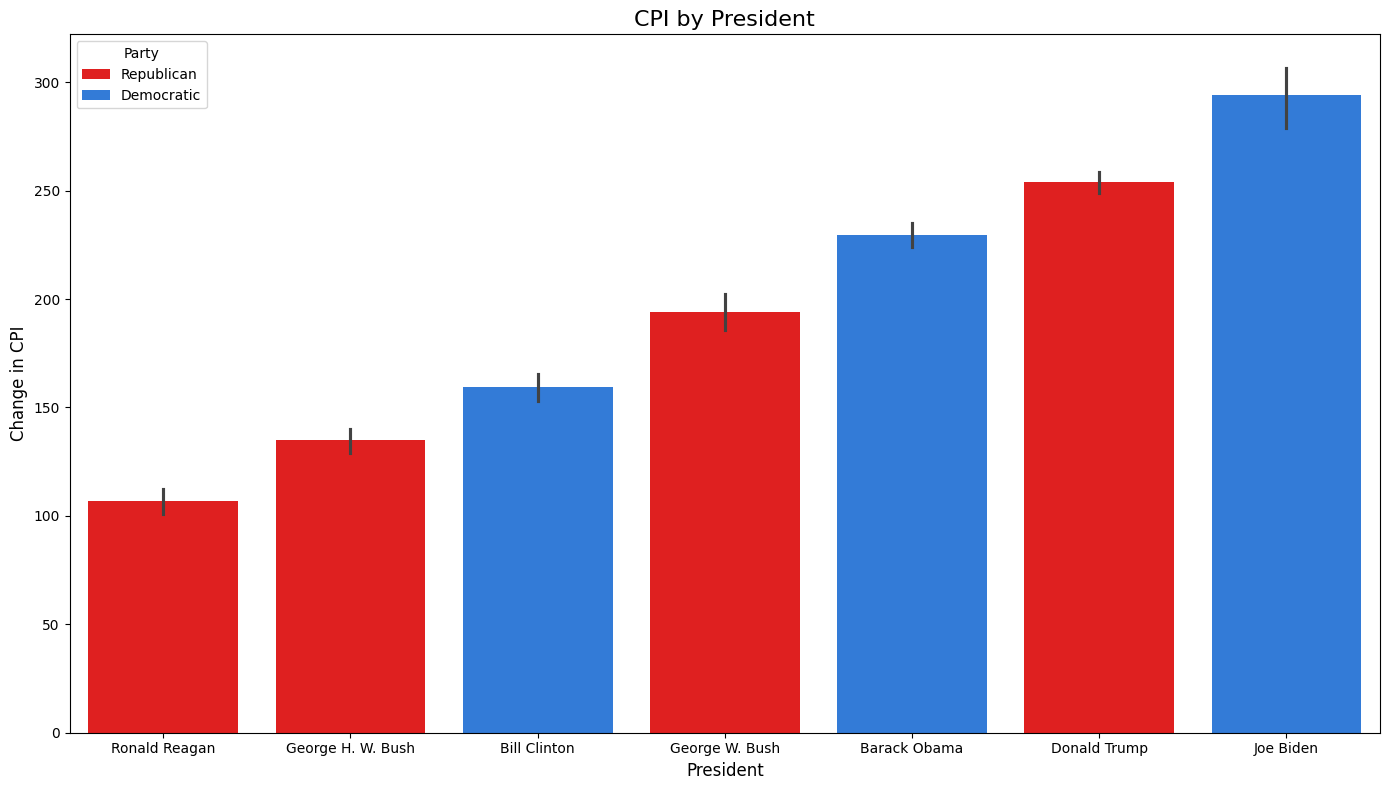

In [137]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Create the bar plot for change in CPI under each president
sns.barplot(
    x="name",
    y="cpi",
    hue="party",
    data=stats_df,
    palette=party_colors,
    dodge=False,
)

# Set axis labels and title
plt.title("CPI by President", fontsize=16)
plt.xlabel("President", fontsize=12)
plt.ylabel("Change in CPI", fontsize=12)

# Add a legend for party affiliation
plt.legend(title="Party")

# Display the plot
plt.tight_layout()
plt.show()